<a href="https://colab.research.google.com/github/armaank/dbn/blob/main/dbn/figure_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
# Clone git
%rm -rf archlectures
!git clone https://github.com/armaank/dbn
%cd dbn/generative/



After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


fatal: destination path 'dbn' already exists and is not an empty directory.
/content/dbn/generative


In [2]:
%%sh
python3 get_models.py

success


tcmalloc: large alloc 1621008384 bytes == 0x64d00000 @  0x7f338abc61e7 0x4a3940 0x5b438c 0x5b46f7 0x59afff 0x515655 0x593dd7 0x511e2c 0x549576 0x593fce 0x511e2c 0x549576 0x593fce 0x511e2c 0x593dd7 0x5118f8 0x549576 0x604173 0x5f5506 0x5f8c6c 0x5f9206 0x64faf2 0x64fc4e 0x7f338a7c3c87 0x5b621a
/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
!pip install torch
!pip install fbpca boto3
!git submodule update --init --recursive
%cd ./ganspace/

<IPython.core.display.Javascript object>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/dbn/generative/ganspace


StyleGAN2, style, a
../models/Adaily-A/torch_official/stylegan2_Adaily_1024.pt
Not cached
[12.07 01:24] Computing stylegan2-Adaily-A_style_ipca_c80_n1000000_w.npz
Reusing InstrumentedModel instance
Using W latent space
Feature shape: torch.Size([1, 512])
B=20, N=1000000, dims=512, N/dims=1953.1


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:300: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:274: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
Fitting batches (NB=2000): 100%|##########| 500/500 [02:19<00:00,  3.58it/s]


Total time: 0:03:39.760009
Too few strips to create grid, creating just strips!


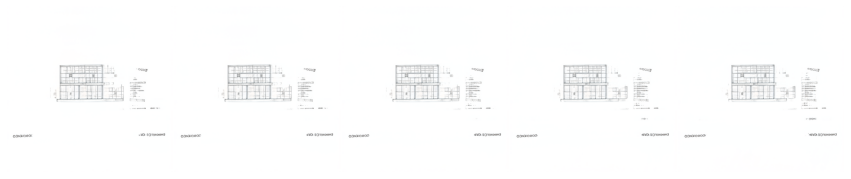

StyleGAN2, style, b
../models/Adaily-B/torch_official/stylegan2_Adaily_1024.pt
Not cached
[12.07 01:28] Computing stylegan2-Adaily-B_style_ipca_c80_n1000000_w.npz
Reusing InstrumentedModel instance
Using W latent space
Feature shape: torch.Size([1, 512])
B=20, N=1000000, dims=512, N/dims=1953.1


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:300: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:274: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
Fitting batches (NB=2000): 100%|##########| 500/500 [02:26<00:00,  3.42it/s]


Total time: 0:03:46.055818
Too few strips to create grid, creating just strips!


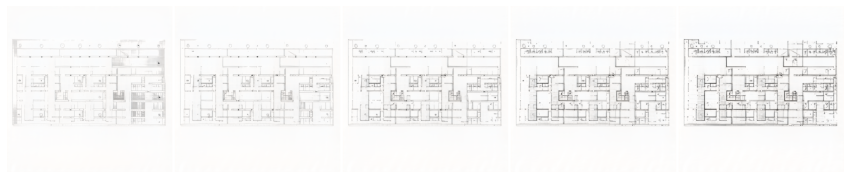

Done


In [5]:
import torch
import numpy as np
from os import makedirs
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pickle

import sys
sys.path.insert(0, '..')
from models import get_instrumented_model, get_model
from notebooks.notebook_utils import create_strip, create_strip_centered, prettify_name, save_frames, pad_frames
from config import Config
from decomposition import get_or_compute

torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

has_gpu = torch.cuda.is_available()
device = torch.device('cuda' if has_gpu else 'cpu')
inst = None
out_root = Path('out/directions')
makedirs(out_root, exist_ok=True)
B = 5

# Model, layer, edit, layer_start, layer_end, class, sigma, idx, name, (example seeds)
configs = [        
    ('StyleGAN2', 'style', 'latent', 'w', 6, 8, 'Adaily-A', -20.0, 43, 'a', [140658858, 1887645531]),
    ('StyleGAN2', 'style', 'latent', 'w', 8, 9, 'Adaily-B', 9.0, 0, 'b', [266415229, 375122892]),
]

has_gpu = torch.cuda.is_available()
device = torch.device('cuda' if has_gpu else 'cpu')

num_imgs_per_example = 1

for config_id, (model_name, layer, mode, latent_space, l_start, l_end, classname, sigma, idx, title, seeds) in enumerate(configs[:]):
    print(f'{model_name}, {layer}, {title}')
    
    inst = get_instrumented_model(model_name, classname, layer, device, inst=inst) # reuse if possible
    model = inst.model
    
    if 'BigGAN' in model_name:
        model.truncation = 0.6
    elif 'StyleGAN2' in model_name:
        model.truncation = 0.7
        
    if latent_space == 'w':
        model.use_w()
    elif hasattr(model, 'use_z'):
        model.use_z()
    
    # Load or compute decomposition
    config = Config(
        output_class = classname,
        model = model_name,
        layer = layer,
        estimator = 'ipca',
        use_w = (latent_space == 'w'),
        n = 1_000_000
    )

    # Special case: BigGAN512-deep, gen_z: class-independent
    if model_name == 'BigGAN-512' and layer == 'generator.gen_z':
        config.output_class = 'husky' # chosen class doesn't matter
    
    dump_name = get_or_compute(config, inst)
    data = np.load(dump_name, allow_pickle=False)
    X_comp = data['act_comp']
    X_global_mean = data['act_mean']
    X_stdev = data['act_stdev']
    Z_global_mean = data['lat_mean']
    Z_comp = data['lat_comp']
    Z_stdev = data['lat_stdev']
    data.close()

    model.set_output_class(classname)
    feat_shape = X_comp[0].shape
    sample_dims = np.prod(feat_shape)
    
    # Transfer to GPU
    components = SimpleNamespace(
        X_comp = torch.from_numpy(X_comp).view(-1, *feat_shape).to('cuda').float(), #-1, 1, C, H, W
        X_global_mean = torch.from_numpy(X_global_mean).view(*feat_shape).to('cuda').float(), # 1, C, H, W
        X_stdev = torch.from_numpy(X_stdev).to('cuda').float(),
        Z_comp = torch.from_numpy(Z_comp).to('cuda').float(),
        Z_stdev = torch.from_numpy(Z_stdev).to('cuda').float(),
        Z_global_mean = torch.from_numpy(Z_global_mean).to('cuda').float(),
    )
    
    num_seeds = ((num_imgs_per_example - 1) // B + 1) * B # make divisible
    max_seed = np.iinfo(np.int32).max
    seeds = np.concatenate((seeds, np.random.randint(0, max_seed, num_seeds)))
    seeds = seeds[:num_seeds].astype(np.int32)
    latents = [model.sample_latent(1, seed=s) for s in seeds]
    
    # Range is exclusive, in contrast to notation in paper
    edit_start = l_start
    edit_end = model.get_max_latents() if l_end == -1 else l_end
    
    batch_frames = create_strip_centered(inst, mode, layer, latents, components.X_comp[idx],
                        components.Z_comp[idx], components.X_stdev[idx], components.Z_stdev[idx],
                        components.X_global_mean, components.Z_global_mean, sigma, edit_start, edit_end)
    save_frames(f'{config_id}_{title}_{mode}', model_name, out_root, batch_frames)
    
    edit_name = prettify_name(title)
    outidr = out_root / model_name / classname / edit_name
    makedirs(outidr, exist_ok=True)

    for ex, frames in enumerate(batch_frames):
        for i, frame in enumerate(frames):
            Image.fromarray(np.uint8(frame*255)).save(outidr / f'cmp{idx}_s{edit_start}_e{edit_end}_{seeds[ex]}_{i}.png')

    # Show first
    plt.figure(figsize=(15,15))
    plt.imshow(np.hstack(pad_frames(batch_frames[0])))
    plt.axis('off')
    plt.show()

print('Done')